In [55]:
import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [56]:
tf.random.set_seed(42)
np.random.seed(42)

In [57]:
INPUT_SHAPE = (224, 224, 3)
NUM_CLASSES = 4
BATCH_SIZE = 32
EPOCHS = 30
FINE_TUNE_EPOCHS = 10
LEARNING_RATE = 0.001
DROPOUT_RATE = 0.3

In [58]:
TRAIN_DIR = "D:\\ML\\Plant_disease_2\\New Plant Diseases Dataset(Augmented)\\New Plant Diseases Dataset(Augmented)\\train"
VAL_DIR = "D:\\ML\\Plant_disease_2\\New Plant Diseases Dataset(Augmented)\\New Plant Diseases Dataset(Augmented)\\valid"

In [59]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2,
    shear_range=0.2,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(224, 224),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    VAL_DIR,
    target_size=(224, 224),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)



Found 3060 images belonging to 4 classes.
Found 1758 images belonging to 4 classes.


In [60]:
base_model = EfficientNetB0(
    weights='imagenet',
    include_top=False,
    input_shape=INPUT_SHAPE,
    pooling='avg'
)

base_model.trainable = False

print(f"Base model loaded: {base_model.name}")
print(f"Base model parameters: {base_model.count_params():,}")

inputs = keras.Input(shape=INPUT_SHAPE)

x = layers.RandomFlip("horizontal")(inputs)
x = layers.RandomRotation(0.1)(x)
x = layers.RandomZoom(0.1)(x)
x = layers.RandomBrightness(0.1)(x)
x = layers.RandomContrast(0.1)(x)

x = keras.applications.efficientnet.preprocess_input(x)

x = base_model(x, training=False)

x = layers.BatchNormalization()(x)
x = layers.Dropout(DROPOUT_RATE)(x)
x = layers.Dense(512, activation='relu', name='dense_1')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(DROPOUT_RATE)(x)
x = layers.Dense(256, activation='relu', name='dense_2')(x)
x = layers.Dropout(DROPOUT_RATE/2)(x)

outputs = layers.Dense(NUM_CLASSES, activation='softmax', name='predictions')(x)

model = keras.Model(inputs, outputs)

print(f"Complete model created!")
print(f"Total parameters: {model.count_params():,}")

Base model loaded: efficientnetb0
Base model parameters: 4,049,571
Complete model created!
Total parameters: 4,844,967


In [61]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [62]:
model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip_2 (RandomFlip)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation_2               │ (None, 224, 224, 3)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom_2 (RandomZoom)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_brightness_2             │ (None, 224, 224, 3)    │             0 │
│ (RandomBrightness)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_contrast_2               │ (None, 224, 224, 3)    │             0 │
│ (RandomContrast)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 1280)           │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,844,967 (18.48 MB)

 Trainable params: 791,812 (3.02 MB)

 Non-trainable params: 4,053,155 (15.46 MB)

In [63]:
callbacks = [
    ModelCheckpoint(
        'best_plant_disease_model.keras',
        monitor='val_accuracy',
        save_best_only=True,
        save_weights_only=False,
        mode='max',
        verbose=1
    ),
    EarlyStopping(
        monitor='val_accuracy',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    )
]

print("Callbacks configured:")
for callback in callbacks:
    print(f"- {callback.__class__.__name__}")

Callbacks configured:
- ModelCheckpoint
- EarlyStopping
- ReduceLROnPlateau


In [64]:
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/30


C:\Users\Devansh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4136 - loss: 1.6824
Epoch 1: val_accuracy improved from -inf to 0.24687, saving model to best_plant_disease_model.keras
96/96 ━━━━━━━━━━━━━━━━━━━━ 188s 2s/step - accuracy: 0.4140 - loss: 1.6815 - val_accuracy: 0.2469 - val_loss: 1.5362 - learning_rate: 0.0010
Epoch 2/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 930ms/step - accuracy: 0.4978 - loss: 1.4367
Epoch 2: val_accuracy did not improve from 0.24687
96/96 ━━━━━━━━━━━━━━━━━━━━ 134s 1s/step - accuracy: 0.4977 - loss: 1.4369 - val_accuracy: 0.2469 - val_loss: 1.6978 - learning_rate: 0.0010
Epoch 3/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 962ms/step - accuracy: 0.4597 - loss: 1.4310
Epoch 3: val_accuracy did not improve from 0.24687
96/96 ━━━━━━━━━━━━━━━━━━━━ 138s 1s/step - accuracy: 0.4600 - loss: 1.4303 - val_accuracy: 0.2469 - val_loss: 1.6188 - learning_rate: 0.0010
Epoch 4/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 897ms/step - accuracy: 0.5045 - loss: 1.3577
Epoch 4: val_accuracy did not improve from 0.246

In [66]:
print("="*50)
print("STAGE 2: Fine-tuning with unfrozen base model")
print("="*50)

# Unfreeze the base model
base_model.trainable = True

# Use a lower learning rate for fine-tuning
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE/10),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print(f"Base model unfrozen. Trainable parameters: {model.count_params():,}")

# Continue training with fine-tuning
fine_tune_history = model.fit(
    train_generator,
    epochs=EPOCHS + FINE_TUNE_EPOCHS,
    initial_epoch=len(history.history['loss']),
    validation_data=val_generator,
    callbacks=callbacks,
    verbose=1
)


STAGE 2: Fine-tuning with unfrozen base model
Base model unfrozen. Trainable parameters: 4,844,967
Epoch 12/40
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.5617 - loss: 1.1394
Epoch 12: val_accuracy did not improve from 0.24687
96/96 ━━━━━━━━━━━━━━━━━━━━ 493s 5s/step - accuracy: 0.5625 - loss: 1.1375 - val_accuracy: 0.2469 - val_loss: 1.4312 - learning_rate: 1.0000e-04
Epoch 13/40
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7264 - loss: 0.7323
Epoch 13: val_accuracy did not improve from 0.24687
96/96 ━━━━━━━━━━━━━━━━━━━━ 459s 5s/step - accuracy: 0.7265 - loss: 0.7321 - val_accuracy: 0.2469 - val_loss: 2.0041 - learning_rate: 1.0000e-04
Epoch 14/40
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7452 - loss: 0.6907
Epoch 14: val_accuracy improved from 0.24687 to 0.35552, saving model to best_plant_disease_model.keras
96/96 ━━━━━━━━━━━━━━━━━━━━ 476s 5s/step - accuracy: 0.7453 - loss: 0.6907 - val_accuracy: 0.3555 - val_loss: 1.5893 - learning_rate: 1.0000e-04
Epoch 15/

In [67]:
for key in history.history.keys():
    history.history[key].extend(fine_tune_history.history[key])

print("Fine-tuning completed!")

Fine-tuning completed!


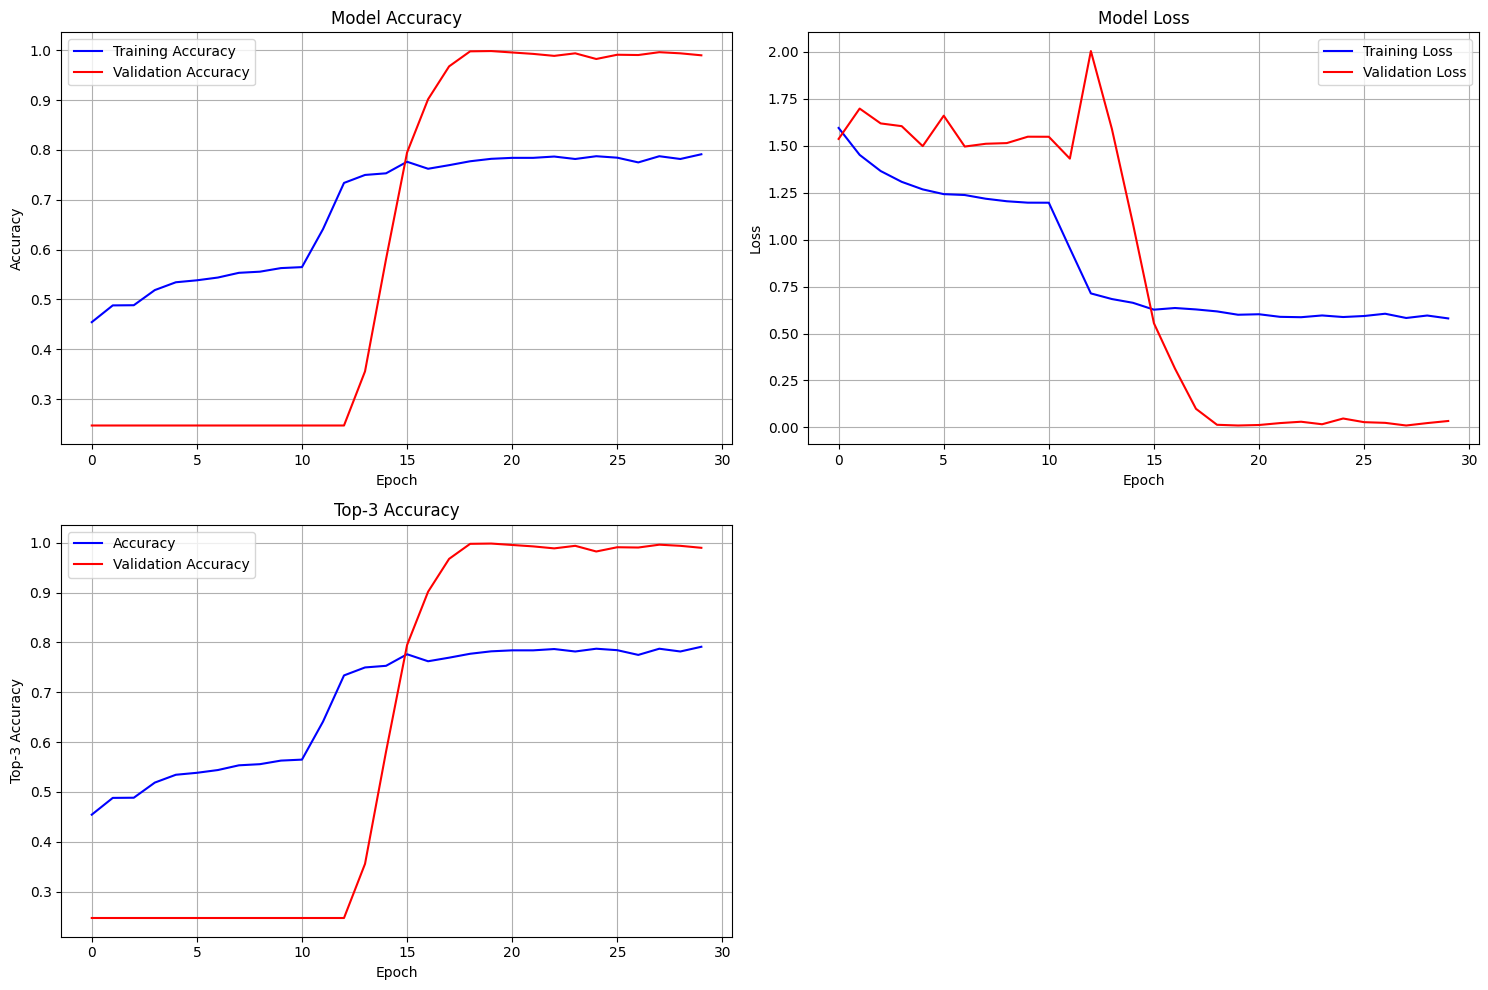

Final Training Accuracy: 0.7912
Final Validation Accuracy: 0.9898
Best Validation Accuracy: 0.9983


In [70]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot training & validation accuracy
axes[0, 0].plot(history.history['accuracy'], label='Training Accuracy', color='blue')
axes[0, 0].plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
axes[0, 0].set_title('Model Accuracy')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].legend()
axes[0, 0].grid(True)

# Plot training & validation loss
axes[0, 1].plot(history.history['loss'], label='Training Loss', color='blue')
axes[0, 1].plot(history.history['val_loss'], label='Validation Loss', color='red')
axes[0, 1].set_title('Model Loss')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].legend()
axes[0, 1].grid(True)

# Plot top-3 accuracy
axes[1, 0].plot(history.history['accuracy'], label='Accuracy', color='blue')
axes[1, 0].plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
axes[1, 0].set_title('Top-3 Accuracy')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Top-3 Accuracy')
axes[1, 0].legend()
axes[1, 0].grid(True)

# Plot learning rate if available
if 'lr' in history.history:
    axes[1, 1].plot(history.history['lr'], label='Learning Rate', color='green')
    axes[1, 1].set_title('Learning Rate Schedule')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Learning Rate')
    axes[1, 1].set_yscale('log')
    axes[1, 1].legend()
    axes[1, 1].grid(True)
else:
    axes[1, 1].axis('off')

plt.tight_layout()
plt.show()

# Print final training results
print(f"Final Training Accuracy: {history.history['accuracy'][-1]:.4f}")
print(f"Final Validation Accuracy: {history.history['val_accuracy'][-1]:.4f}")
print(f"Best Validation Accuracy: {max(history.history['val_accuracy']):.4f}")
